In [114]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [115]:
# Load merged player data (fm_inside + official_info)
with open('/Users/jooyong/github_locals/CSCI5525_project/merged_player_data.json') as f:
  merged_data = json.load(f)

In [116]:
# Count how many field player or goal keeper there are.
# There are some players that position is not defined.

count_field = 0
count_keeper = 0

unspecified_position_player = []

for i in merged_data.keys():
    
    if 'position' in list(merged_data[i]['entity']['info'].keys()):
        
        if merged_data[i]['entity']['info']['position']!='G':
            count_field+=1
            
        else:
            count_keeper+=1
            
    else:
            unspecified_position_player.append(i)


In [117]:
print('The number of players whose position is not defined:', len(merged_data) - (count_field + count_keeper))
print('The number of field players:', count_field)
print('The number of goal keepers:', count_keeper)

The number of players whose position is not defined: 3
The number of field players: 3139
The number of goal keepers: 268


In [118]:
print('key of unspecified position players...\n')
for i in unspecified_position_player:
    print(i)

key of unspecified position players...

187
246
2367


In [119]:
# Function 'most_att()' returns players' attributes' names and 
# the total number of the existence of each attribute in descending order.

def most_att(field_or_keeper):

    
    list_keys_players = []
    for i in merged_data.keys():
        if 'position' in list(merged_data[i]['entity']['info'].keys()):

            if field_or_keeper == 'field':

                if merged_data[i]['entity']['info']['position']!='G':
                    list_keys_players.append(i)

            if field_or_keeper == 'keeper':

                if merged_data[i]['entity']['info']['position']=='G':
                    list_keys_players.append(i)   
                
    list_all_features_players = []
    for i in list_keys_players:
        for k in merged_data[i].keys():
            if k!='fm_data':
                list_all_features_players +=list(merged_data[i]['official_stats'].keys())
                    
    value, counts = np.unique(list_all_features_players, return_counts=True)
    dict_temp = {}
    for i in range(len(value)):
        dict_temp[value[i]]=counts[i]

    players_atts_in_order = sorted(dict_temp.items(), key=lambda item: item[1], reverse=True)        

    return players_atts_in_order


# Function 'percent_players_has_selected_atts()' return the percentage of field players 
# who have selected attributes fully in terms of the number of selected attributes(0~100).

def percent_players_has_selected_atts(field_or_keeper):

    player_atts_in_order_list = []
    for i in range(len(most_att(field_or_keeper))):
        player_atts_in_order_list.append(most_att(field_or_keeper)[i][0])
    

    dict_season_match = {}
    dict_various_match = {}

    for p in range(100):
        
        total_match_per_top_atts = 0
        top = player_atts_in_order_list[:p]
        
        player_keys = []

        for i in merged_data.keys():
            
            if 'position' in list(merged_data[i]['entity']['info'].keys()):

                if field_or_keeper == 'field':
                    if merged_data[i]['entity']['info']['position']!='G':
                        player_keys.append(i)
                    
                if field_or_keeper == 'keeper':
                    if merged_data[i]['entity']['info']['position']=='G':
                        player_keys.append(i)

        for i in player_keys:

            for k in merged_data[i].keys():
                
                count = 0 
                
                if k!='fm_data':
                    for h in top:
                        if h in list(merged_data[i]['official_stats'].keys()):
                            count+=1
                
                if k=='official_stats' and count == p:
                    total_match_per_top_atts += 1 
                

                if k in dict_season_match.keys():
                    dict_season_match[k]+=count

                else:
                    dict_season_match[k]=count

        dict_various_match[p]=total_match_per_top_atts / len(list_keys_field)
    
    return dict_various_match



# Functiom returns players' id who do not have selected attributes fully
def player_dont_have_selec_atts(field_or_keeper):

    player_atts_in_order_list = []
    for i in range(len(most_att(field_or_keeper))):
        player_atts_in_order_list.append(most_att(field_or_keeper)[i][0])

    list_keys_wrong = []
    
    # top 'p' attributes
    p = 21
    top = player_atts_in_order_list[:p]

    for i in merged_data.keys():

        player_keys = []
            
        if 'position' in list(merged_data[i]['entity']['info'].keys()):

            if field_or_keeper == 'field':
                if merged_data[i]['entity']['info']['position']!='G':
                    player_keys.append(i)
                
            if field_or_keeper == 'keeper':
                if merged_data[i]['entity']['info']['position']=='G':
                    player_keys.append(i)

            for i in player_keys:
                for k in merged_data[i].keys():
                    count = 0 
                    if k!='fm_data':
                        for h in top:
                            if h in list(merged_data[i]['official_stats'].keys()):
                                count+=1
                        
                    if k=='official_stats' and count!=p:
                        list_keys_wrong.append(i)

    return list_keys_wrong


In [120]:
most_att('field')[:10]

[('appearances', 9390),
 ('losses', 9249),
 ('wins', 9078),
 ('draws', 9024),
 ('clean_sheet', 8160),
 ('yellow_card', 8133),
 ('goal_assist', 7035),
 ('goals', 6957),
 ('mins_played', 6798),
 ('attempts_conceded_ibox', 6753)]

In [121]:
most_att('keeper')[:10]

[('appearances', 804),
 ('losses', 774),
 ('draws', 741),
 ('wins', 726),
 ('clean_sheet', 720),
 ('mins_played', 573),
 ('attempts_conceded_ibox', 570),
 ('game_started', 570),
 ('accurate_back_zone_pass', 567),
 ('accurate_pass', 567)]

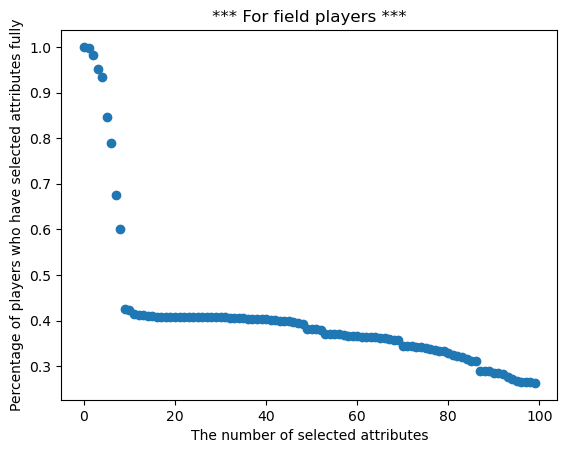

In [122]:
temp = percent_players_has_selected_atts('field')
x_values = list(temp.keys())
y_values = list(temp.values())
plt.scatter(x_values, y_values)
plt.title('*** For field players ***')
plt.xlabel('The number of selected attributes')
plt.ylabel('Percentage of players who have selected attributes fully')
plt.show()

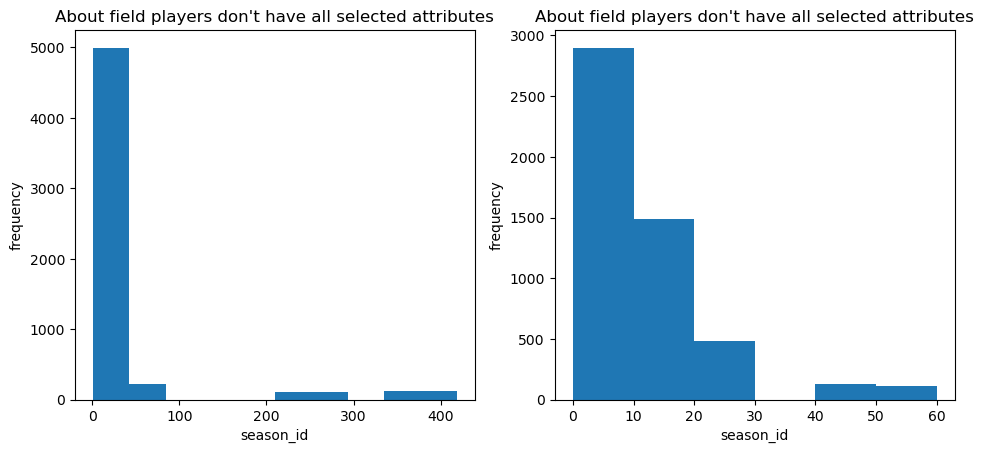

In [127]:
temp = player_dont_have_selec_atts('field')

temp_list = []

for i in temp:
    for k in merged_data[i]['seasons']:
            temp_list.append(int(k))


plt.subplot(121)
plt.hist(temp_list)
plt.title("About field players don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplot(122)
plt.hist(temp_list, bins = [0, 10, 20, 30, 40, 50, 60])
plt.title("About field players don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplots_adjust(right=1.5)

plt.show()

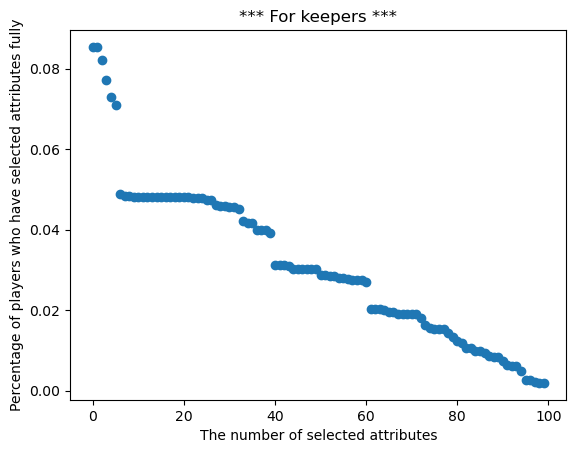

In [124]:
temp = percent_players_has_selected_atts('keeper')
x_values = list(temp.keys())
y_values = list(temp.values())
plt.scatter(x_values, y_values)
plt.title('*** For keepers ***')
plt.xlabel('The number of selected attributes')
plt.ylabel('Percentage of players who have selected attributes fully')
plt.show()

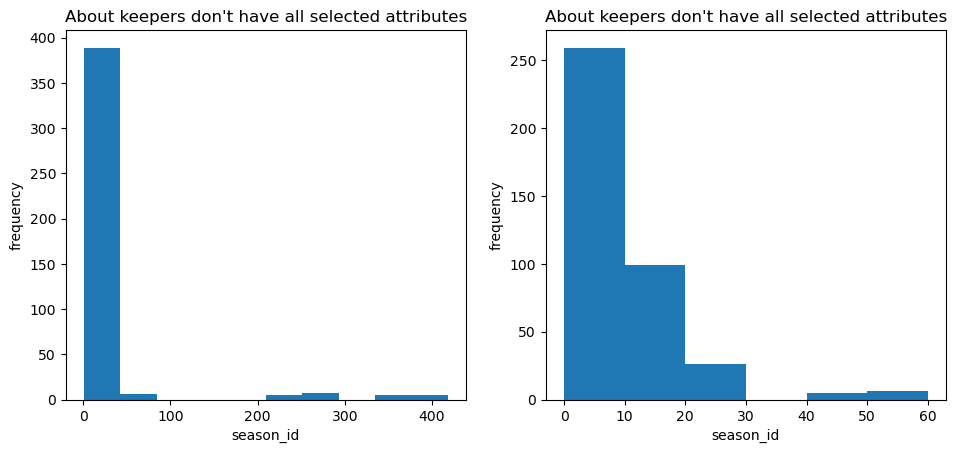

In [128]:
temp = player_dont_have_selec_atts('keeper')

temp_list = []

for i in temp:
    for k in merged_data[i]['seasons']:
            temp_list.append(int(k))


plt.subplot(121)
plt.hist(temp_list)
plt.title("About keepers don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplot(122)
plt.hist(temp_list, bins = [0, 10, 20, 30, 40, 50, 60])
plt.title("About keepers don't have all selected attributes")
plt.xlabel('season_id')
plt.ylabel('frequency')

plt.subplots_adjust(right=1.5)

plt.show()